In [1]:
import torch
from supervoice_valle import SupervoceNARModel, Tokenizer
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from vocos import Vocos

In [2]:
vocos = Vocos.from_pretrained("charactr/vocos-encodec-24khz")
tokenizer = Tokenizer("./tokenizer_text.model")
model = SupervoceNARModel()
checkpoint = torch.load("./output/valle-05.pt")
model.load_state_dict(checkpoint['model'])
model = model.to(torch.float16)
model = model.to("cuda")
model.eval()
step = checkpoint['step']
print(checkpoint['step'])

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


37000


In [3]:
id = "./external_datasets/libriheavy-encodec/9774/extermination_american_bison_1503_librivox_64kb_mp3/exterminationamericanbison_12_hornaday_64kb_99"
with open(id + ".txt", 'r') as file:
    text = file.read()
    text = tokenizer.encode(text)
encoded = torch.load(id + ".pt")

In [4]:
def decode(tokens):
    features = vocos.codes_to_features(tokens)
    bandwidth_id = torch.tensor([2])  # 6 kbps
    return vocos.decode(features, bandwidth_id=bandwidth_id)
display(Audio(data=decode(encoded).cpu(), rate=24000))
print(encoded.shape)

torch.Size([8, 936])


In [5]:
condition_text = text
condition_audio = encoded[:,0:75*3]
audio = encoded[:,75*3:]
predicted = [audio[0]]
for i in range(1, 8):
    p = model(
        condition_text = condition_text.to("cuda"), 
        condition_audio = condition_audio.to("cuda"),
        audio = audio.to("cuda"),
        codec = i
    )
    p = torch.nn.functional.softmax(p, dim=-1)
    p = torch.argmax(p, dim=-1)
    predicted.append(p.cpu())
predicted = torch.stack(predicted)
predicted = torch.cat([condition_audio, predicted], dim = 1)
display(Audio(data=decode(predicted).cpu(), rate=24000))

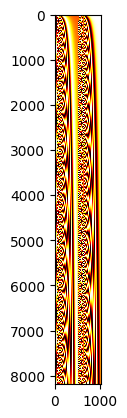

In [6]:
plt.imshow(model.positional_embedding.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [7]:
model_t = SupervoceNARModel()
for i in range(1, 10):
    checkpoint = torch.load("./output/valle-05." + str(step - i * 1000) + ".pt")
    model_t.load_state_dict(checkpoint['model'])
    model_t = model_t.to(torch.float16)
    model_t = model_t.to("cuda")
    predicted = [audio[0]]
    for i in range(1, 8):
        p = model_t(
            condition_text = condition_text.to("cuda"), 
            condition_audio = condition_audio.to("cuda"),
            audio = audio.to("cuda"),
            codec = i
        )
        p = torch.nn.functional.softmax(p, dim=-1)
        p = torch.argmax(p, dim=-1)
        predicted.append(p.cpu())
    predicted = torch.stack(predicted)
    predicted = torch.cat([condition_audio, predicted], dim = 1)
    display(Audio(data=decode(predicted).cpu(), rate=24000))